Copyright 2020-2022 Universidad Complutense de Madrid

This file software has been employed to calibrate infrared spectroscopic data from the EMIR instrument at GTC (see [Paliya et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...903L...8P/abstract))

Authors: Cristina Cabello (criscabe@ucm.es), Nicolás Cardiel (cardiel@ucm.es) Jesús Gallego (j.gallego@ucm.es)

SPDX-License-Identifier: GPL-3.0+ License-Filename: LICENSE.txt

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
mpl.rcParams['font.family'] = 'serif'

from astropy.io import fits
from astropy.stats import mad_std, sigma_clipped_stats
import astropy.units as u
from dust_extinction.parameter_averages import F99
import numpy as np
import pandas as pd
from photutils import aperture_photometry
from photutils import CircularAperture, CircularAnnulus
from photutils import DAOStarFinder
from synphot import Observation, SourceSpectrum, SpectralElement
from synphot import units
from synphot.models import Empirical1D

from numina.array.stats import robust_std

from der_snr import der_snr

# <span style="color:red">Calibrating the EMIR Ks spectrum of the J1219 object</span>  

### In this notebook, we carry out:
### - The flux calibration
### - The telluric correction
### - The flux correction due to light losses
### - The Galactic extinction correction
### - S/N estimation

----------------------------------------------------------------------------

##  <span style="color:blue"> ---> FLUX CALIBRATION and TELLURIC CORRECTION</span> 

First, we combined the two science images generated by PyEmir by applying the mean on the J1219 data taken on two different nights. Before this combination, we checked that there was no spatial offset (Y direction) between the spectra of the two images. 

The we read the 2D reduced image ('sp2dc.fits') and extract the 1D spectrum in units of ADU/s. 

naxis1, naxis2: 3400, 2090
exptime: 359.986465


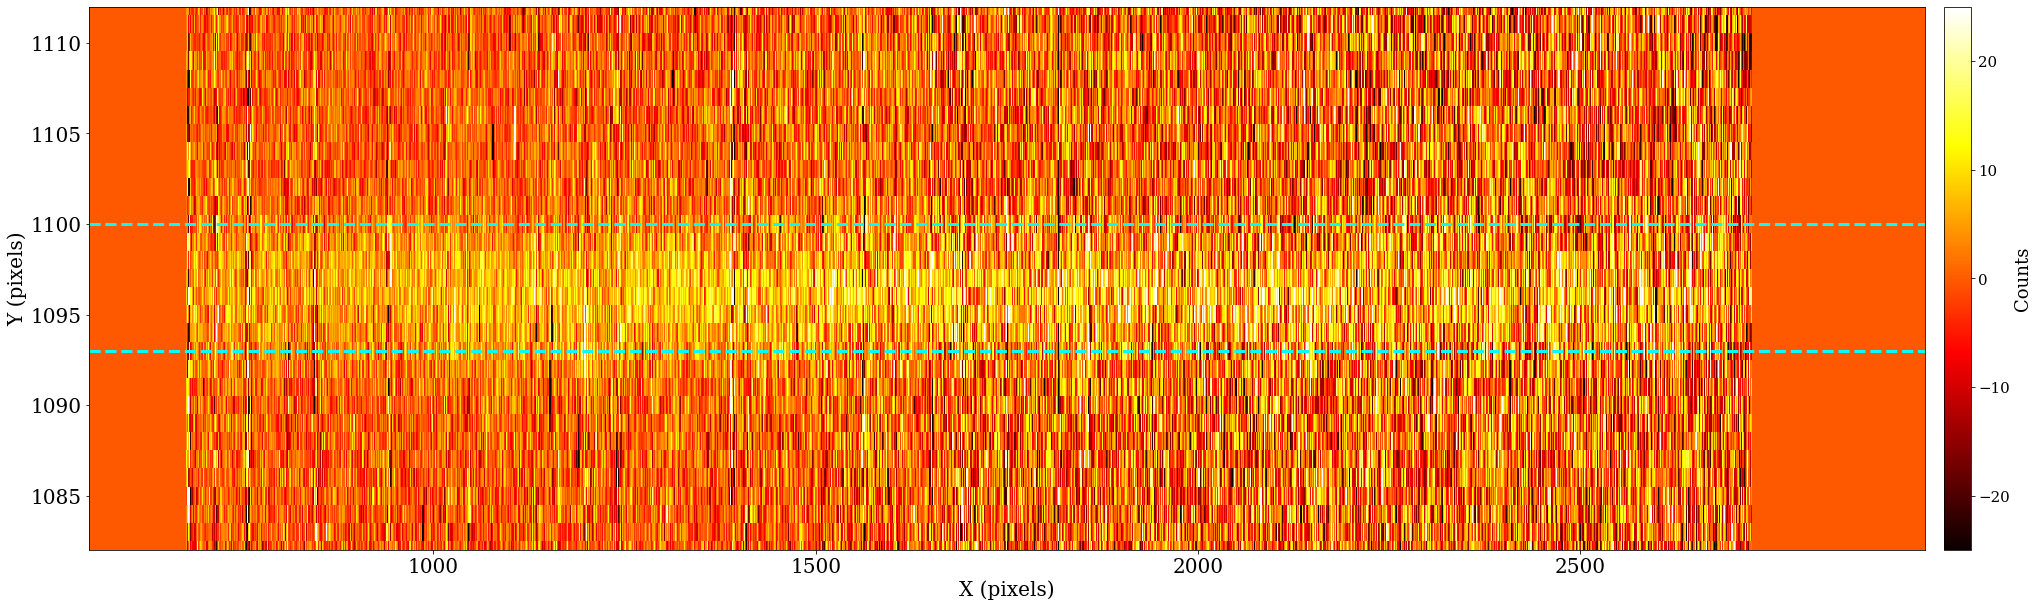

In [29]:
with fits.open('sp2dc.fits') as hdul:
    header = hdul[0].header
    image2d = hdul[0].data
naxis1 = header['naxis1']
naxis2 = header['naxis2']
print('naxis1, naxis2: {}, {}'.format(naxis1, naxis2))
exptime = float(header['exptime'])
print('exptime: {}'.format(exptime))



fig, ax = plt.subplots(figsize=(35,10))
cmap = ax.imshow(image2d, cmap='hot', aspect='auto', interpolation='nearest',
                 origin='lower', vmin=-25, vmax= 25)
cb = plt.colorbar(cmap,fraction=0.05, pad=0.01) 
cb.ax.tick_params(labelsize=15)
cb.set_label('Counts', fontsize=18,family='serif')
ax.set_xlabel('X (pixels)', fontsize=20,family='serif')
ax.set_ylabel('Y (pixels)', fontsize=20,family='serif')
plt.yticks(fontname = 'serif', size=20)
plt.xticks(fontname = 'serif', size=20)
ax.axhline(1093, color='cyan', linestyle='dashed',linewidth=3)
ax.axhline(1100, color='cyan', linestyle='dashed',linewidth=3)
plt.xlim(550,2950)
plt.ylim(1082,1112)
plt.show()


sp = np.sum(image2d[(1093):(1100), :], axis=0)/exptime


To carry out the flux calibration of the target spectrum, we observed the spectro-photometric standard star HD116405 with the same instrument setup (EMIR K-band long-slit mode).
We read the file derived in '1_Response_curve_EMIR.ipynb' which contains the wavelength, the response curve, and the continuum boundaries derived with **boundfit**. 


The fit to the stellar continuum corresponds with the variable **cont1** (orange line, left panel).

The response curve is **cont2** (blue line, left panel)

The telluric correction (**telcorr**) is computed as **cont2** / **cont1** (right panel). Te different colors stands for different values of the correction factor responsible to adjust the depth of the absorptions. 

The correction of this depth is very important when the target and the standard star are observed at different airmasses. For this task, we used the following equation:

${\rm SP}_{\rm calibrated} = \frac{\rm SP}{cont1 \cdot (1 + ({\rm telcorr} - 1) \cdot {\rm Factor})}$

where SP$_{\rm calibrated}$ is the calibrated target spectrum in erg s$^{-1}$ cm$^{-2}$ Å, SP is the original target spectrum in ADUs/s, cont1 is the fit to the stellar continuum in the response curve, telcorr is defined as telcorr = $\frac{\rm cont2}{\rm cont1}$, and the Factor parameter is a constant to adjust the depth of the absorptions.


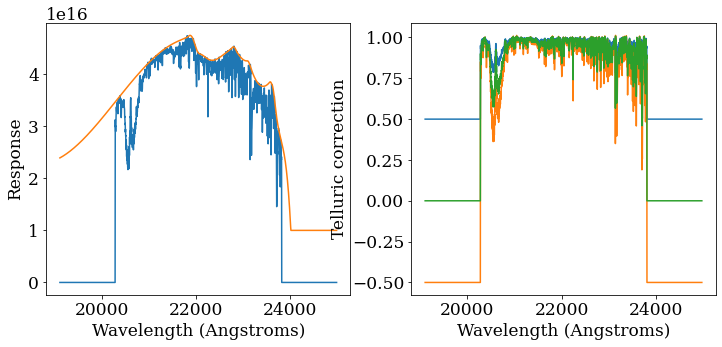

In [30]:
resptable = np.genfromtxt('../standard_stars/response.txt')
wave = resptable[:, 0]
response = resptable[:, 1]
cont1 = resptable[:, 2]
cont1[cont1 < 1E16] = 1E16  # Avoid zero values
cont2 = resptable[:, 3]

telcorr = cont2/cont1

fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
ax1, ax2 = axarr
ax1.plot(wave, response)
ax1.plot(wave, cont1)
ax1.set_xlabel('Wavelength (Angstroms)')
ax1.set_ylabel('Response')
ax2.plot(wave, 1+(telcorr-1)*0.5)
ax2.plot(wave, 1+(telcorr-1)*1.5)
ax2.plot(wave, telcorr)
ax2.set_xlabel('Wavelength (Angstroms)')
ax2.set_ylabel('Telluric correction')
plt.show()

We determined this constant by 'trial and error', increasing and decreasing the depth of the absorptions until they match the continuum of our target spectrum. We found that Factor = 1.0 works well for the telluric correction of our J1219 spectrum. This implies that, in the end, we did not need to correct the depth of the absorptions, which makes sense because the airmass was similar during the observations of the standard star (airmass = 1.33) and for those of the target (airmass = 1.27). Hence, in this case the previous equation is simplified to: 

${\rm SP}_{\rm calibrated} = \frac{\rm SP}{Response \, curve}$


We compared the calibrated spectrum of J1219 with (orange) and without (blue) the telluric correction. 
As shown in the figure below, this correction does not seriously affect our target spectrum and only in the region around 2.07~$\mu$m is noticeable.


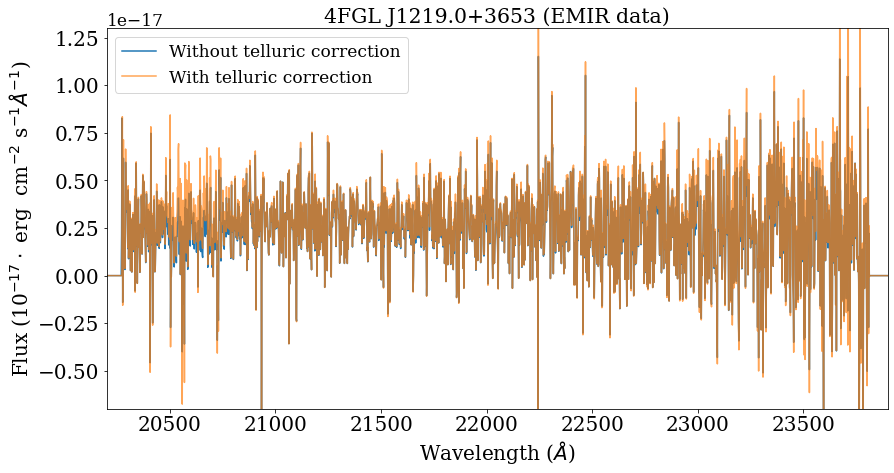

In [32]:

spcalibrated_ini = np.zeros(naxis1)
iok = np.where(cont2 > 0)
spcalibrated_ini[iok] = sp[iok]/cont2[iok] # cont2 = response curve


# Equivalent to --->   spcalibrated_ini = sp/(cont1*(1+(telcorr-1)*1.0))



fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(wave, sp/cont1, label='Without telluric correction')
ax.plot(wave, spcalibrated_ini, label='With telluric correction', alpha=0.7)
ax.set_xlabel('Wavelength ($\AA$)', size=20)
ax.set_ylabel('Flux (10$^{-17} \cdot$ erg  cm$^{-2}$ s$^{-1} \AA^{-1}$)', size=20)
ax.set_title('4FGL J1219.0+3653 (EMIR data)')
ax.legend()
ax.set_xlim(20200,23900)
ax.set_ylim(-0.7*10**-17,1.3*10**-17)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('plots/telluric_correction.pdf',  bbox_inches='tight')
plt.show()


##  <span style="color:blue"> ---> FLUX CORRECTION</span> 

Once the spectrum of our target is flux calibrated, we computed the Ks synthetic magnitude using the **synphot** package.

First, we set to constant (median value) the blue and red parts of the spectrum without signal.

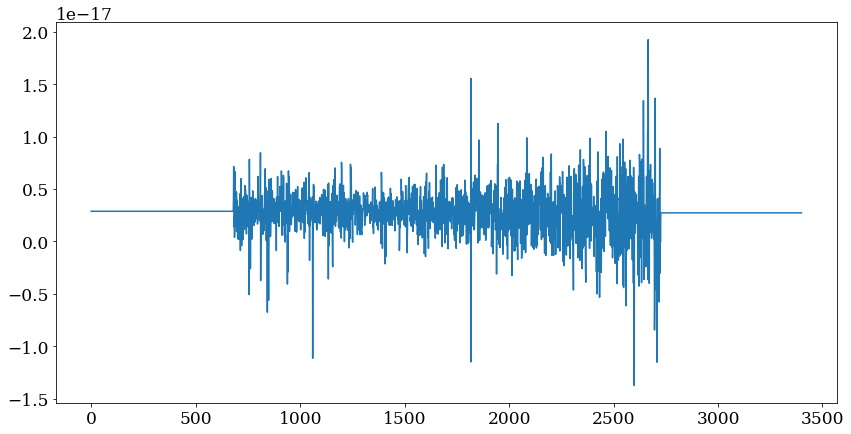

In [34]:
sptemp = spcalibrated_ini.copy()
sptemp[0:681] = np.median(spcalibrated_ini[680:1000])
sptemp[2726:] = np.median(spcalibrated_ini[2000:2726])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(sptemp)

Then, we define the spectrum and the corresponding Ks filters in the EMIR (from http://www.gtc.iac.es/instruments/emir/emir.php#BroadBand_Imaging) and 2MASS (from https://old.ipac.caltech.edu/2mass/releases/allsky/doc/sec3_1b1.html#s11) systems. 

Note that the initial file has to be sorted and the first column transformed from microns to angstroms.


  points: [20335.22 20345.6  20406.15 20418.26 20503.03 20506.49 20558.39 20565.31
 20568.77 20632.78 20705.44 20724.47 20727.93 20729.66 20907.85 20933.8
 20935.53 21063.55 21067.01 21098.15 21099.88 21196.76 21233.09 21264.23
 21501.24 21511.62 21532.38 21541.03 21651.75 21715.76 21807.45 21857.62
 21859.35 21868.   21892.22 22006.4  22028.89 22054.84 22122.31 22151.72
 22207.08 22217.46 22239.95 22243.41 22302.23 22414.68 22421.6  22428.52
 22456.2  22476.96 22480.42 22483.88 22509.83 22540.97 22546.16 22547.89
 22584.22 22603.25 22608.44 22617.09 22625.74 22627.47 22629.2  22630.93
 22655.15 22663.8  22665.53 22670.72 22672.45 22684.56 22696.67 22745.11
 22758.95 22764.14 22774.52 22786.63 22793.55 22854.1  22864.48 22904.27
 22914.65 22928.49 22945.79 22966.55 22980.39 23006.34 23008.07 23016.72
 23034.02 23044.4  23046.13 23053.05 23063.43 23065.16 23087.65 23089.38
 23091.11 23092.84 23115.33 23129.17 23146.47 23156.85 23163.77 23170.69
 23181.07 23182.8  23191.45 23193.18 23194

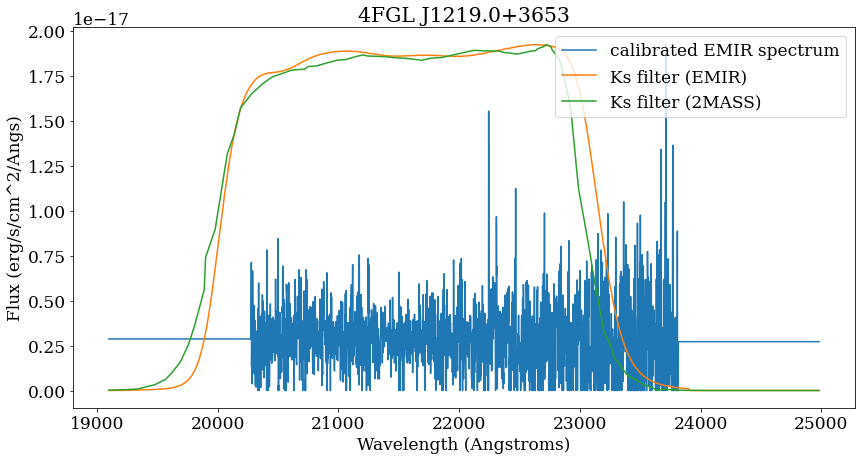

In [35]:
# define spectrum
src_spectrum = SourceSpectrum(Empirical1D, points=wave, lookup_table=sptemp*units.FLAM)

# define bandpass corresponding to Ks (from http://www.gtc.iac.es/instruments/emir/emir.php#BroadBand_Imaging)
# note: the initial file has to be sorted and the first column transformed from microns to angstroms:
# $ tail -r K_short.txt > xxx.txt
# $ cat xxx.txt | awk '{print $1*10000 "  " $2}' > K_short_angstroms.txt

bp_ksmag = SpectralElement.from_file('K_short_angstroms.txt')

# idem with the Ks filter form 2MASS (from https://old.ipac.caltech.edu/2mass/releases/allsky/doc/sec3_1b1.html#s11)
# note: the initial table has 3 columns; we store the initial table as Ks_2mass_ini.txt and then:
# $ cat Ks_2mass_ini.txt | awk '{print $2*10000 "  " $3*100}' > Ks_2mass.txt

bp_ksmag_2mass = SpectralElement.from_file('Ks_2mass.txt')

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(wave, src_spectrum(wave, flux_unit=units.FLAM), label='calibrated EMIR spectrum')
ax.plot(wave, bp_ksmag(wave)/max(bp_ksmag(wave))*max(sptemp), label="Ks filter (EMIR)")
ax.plot(wave, bp_ksmag_2mass(wave)/max(bp_ksmag_2mass(wave))*max(sptemp), label="Ks filter (2MASS)")
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (erg/s/cm^2/Angs)')
ax.set_title('4FGL J1219.0+3653')
ax.legend(loc=1)

Since the 2MASS magnitude system is based on Vega, we need to measure Vega magnitudes.

The Vega spectrum can be downloaded from: https://ssb.stsci.edu/trds/calspec/alpha_lyr_stis_010.fits

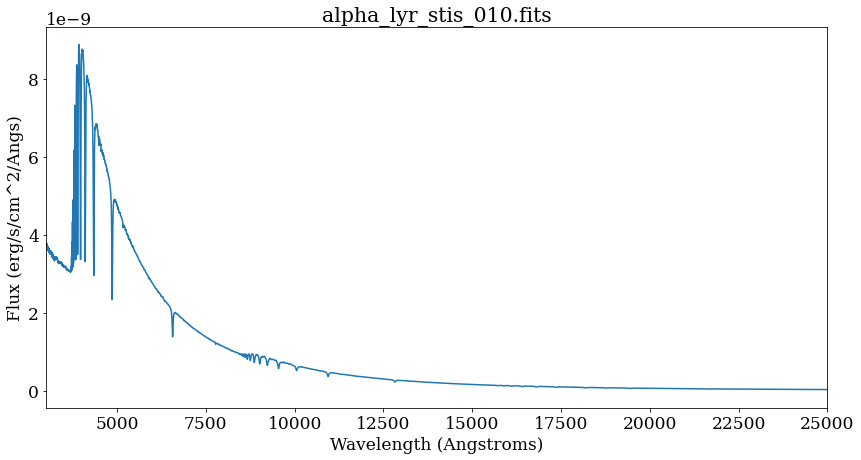

In [38]:

vega_fname = 'alpha_lyr_stis_010.fits'
vegaspec = SourceSpectrum.from_file(vega_fname)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
wave_vega = vegaspec.waveset
ax.plot(wave_vega, vegaspec(wave_vega, flux_unit=units.FLAM))
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Flux (erg/s/cm^2/Angs)')
ax.set_title(vega_fname)
ax.set_xlim([3000, 25000])
plt.show()

We compute the Ks synthetic magnitude (Vega system) for both the Ks bandpass of EMIR and 2MASS, and the difference magnitude between these two systems.

In [39]:
obs = Observation(src_spectrum, bp_ksmag)
ksmag_synthetic_emir = obs.effstim(flux_unit='vegamag', vegaspec=vegaspec)
print("Ks (EMIR).........: {}".format(ksmag_synthetic_emir))
obs = Observation(src_spectrum, bp_ksmag_2mass)
ksmag_synthetic_2mass = obs.effstim(flux_unit='vegamag', vegaspec=vegaspec)
print("Ks (2MASS)........: {}".format(ksmag_synthetic_2mass))
ksmag_filter_correction = ksmag_synthetic_emir.value - ksmag_synthetic_2mass.value
print("Delta Ks magnitude: {}".format(ksmag_filter_correction))

Ks (EMIR).........: 17.913732904886977 VEGAMAG
Ks (2MASS)........: 17.92958024490129 VEGAMAG
Delta Ks magnitude: -0.015847340014314426


Furthermore, we decided to refine our flux calibration by computing a flux correction factor to account for light losses due to the seeing being slightly larger than the slit width. For this task, we carried out the photometric calibration of the acquisition image using the available Ks 2MASS photometric data. 

We read this acquisition image taken with the EMIR Ks filter. After cropping the image to reduce the size, we plot the image and highlight the position of the J1219 source.  

In [40]:
infile = 'acquisition_emir.fits'
with fits.open(infile) as hdul:
    data = np.rot90(np.flip(hdul[0].data, axis=0), 1)
    
# set to zero pixel values below -1000 counts (to reduce de impact of negative images)
data[data<-500] = 0
    
# crop image
nx1, nx2, ny1, ny2 = 100, 2048-100, 100, 2048-100
data = data[ny1:ny2, nx1:nx2]


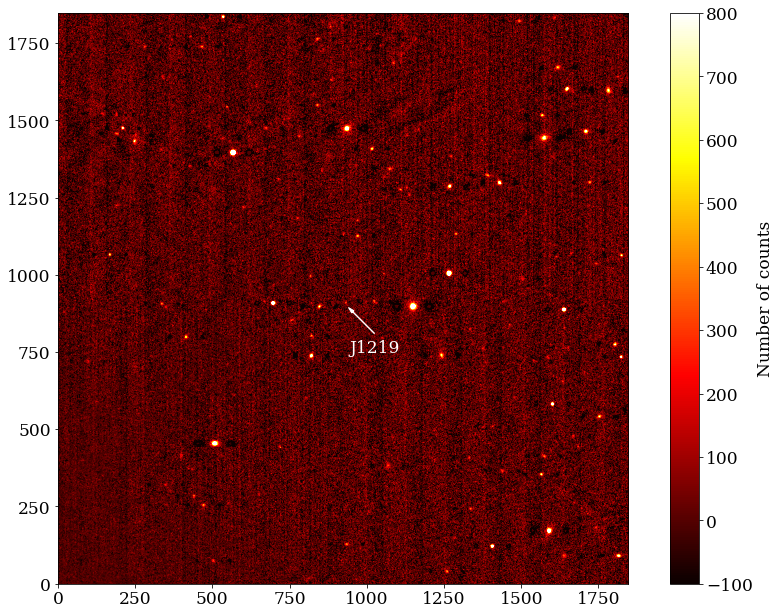

In [41]:
plotwidth = 15
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(plotwidth, plotwidth*0.7))
im = ax.imshow(data, origin='lower', vmin=-100, vmax=800, cmap='hot', aspect='equal')
plt.colorbar(im, orientation='vertical', ax=ax, label='Number of counts')
ax.arrow(925+100, 910-100, -70, 70, color='white', head_width=10, head_length=20)
ax.text(1025, 750, 'J1219', ha='center', color='white')
plt.show()

First, we employed the 'DAOStarFinder' function of **photutils** to detect peaks above a certain threshold in the acquisition image. We selected only the brightest sources and performed aperture photometry. 

In [49]:
bkg_sigma = mad_std(data)
daofind = DAOStarFinder(fwhm=10, threshold=3.*bkg_sigma) 
sources = daofind(data)
for col in sources.colnames:
    sources[col].info.format = '%.8g'   # for consistent table output
    
print(sources)

 id  xcentroid ycentroid sharpness  ... sky    peak      flux        mag     
---- --------- --------- ---------- ... --- --------- --------- -------------
   1 1124.1992 2.7567343 0.50100453 ...   0 153.49951 1.0214566  -0.023049781
   2 1447.1389 5.1960036 0.64902661 ...   0 175.33398 1.1552677   -0.15670659
   3 1666.2716  12.21133 0.22975846 ...   0 39.833984 1.0088065 -0.0095196635
   4 995.54916 13.720312 0.31434892 ...   0 87.333008 1.0497534  -0.052718188
   5 964.67676 14.883849 0.65245668 ...   0 254.33398 1.2567601   -0.24813098
   6 1027.2629 16.855246 0.52574011 ...   0      96.5 1.0878688  -0.091441345
   7 811.65233 18.698657 0.56989727 ...   0 236.83398 1.1835044   -0.18292472
   8 1770.3205 19.390385 0.40184245 ...   0 151.16602 1.2025213   -0.20023194
   9  1804.841 18.876043 0.67179821 ...   0 188.83301   1.24562   -0.23846391
  10 1415.8621 21.763011 0.53754235 ...   0     134.5 1.1253253   -0.12819522
 ...       ...       ...        ... ... ...       ...       ... 

In order to select only the brightest objects, we plot the number of sources as a function of the peak signal:

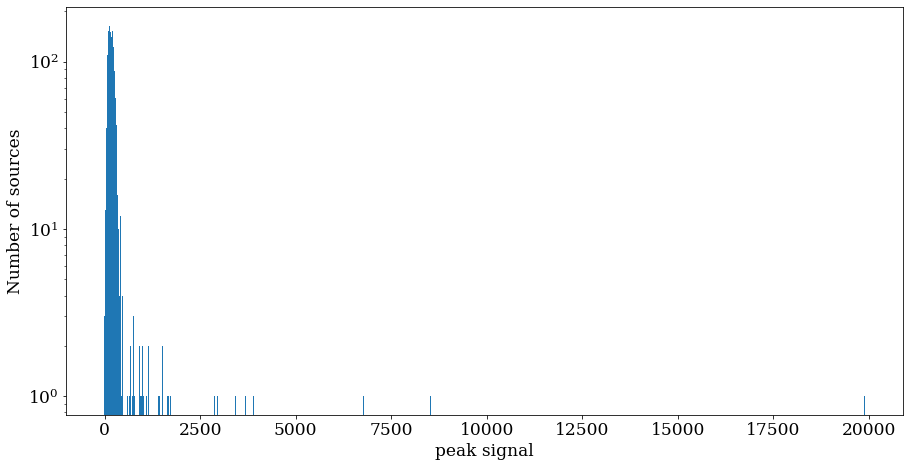

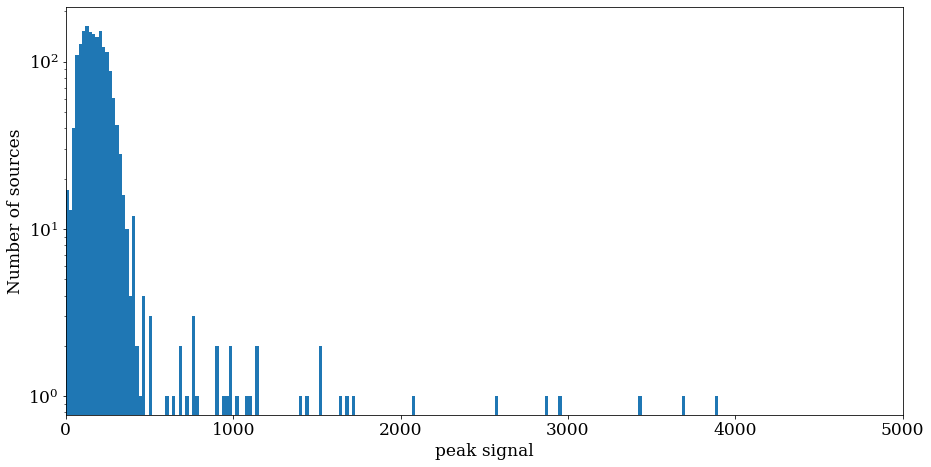

In [50]:
for iplot in range(2):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(plotwidth, plotwidth/2))
    ax.hist(sources['peak'], bins=1000)
    ax.set_yscale('log')
    ax.set_xlabel('peak signal')
    ax.set_ylabel('Number of sources')
    if iplot == 1:
        ax.set_xlim([0,5000])

In [51]:
# we select only the brightest objects
sources = sources[sources['peak'] > 1000]
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
48,1814.0736,91.1646,0.41168259,-0.40354596,-0.50910818,169,0,1144.834,5.4089576,-1.832784
63,1404.7617,122.09337,0.66520955,-0.029937155,-0.084758354,169,0,3423.083,14.832817,-2.9280591
98,1588.8728,171.92114,0.50999044,-0.059403101,0.10289864,169,0,2956.916,12.364366,-2.7304296
310,506.85124,454.44465,0.8107531,0.089563428,-0.26564722,169,0,3896,11.717266,-2.6720658
384,1751.8131,541.99077,0.60394805,0.12735106,-0.25862993,169,0,1021.333,4.1740978,-1.5514066
410,1599.6248,582.35341,0.51683087,-0.053385075,0.011488719,169,0,2868.6675,14.795742,-2.9253418
533,1821.9857,734.83884,0.57668514,-0.027906727,0.11272838,169,0,1638.667,8.0022536,-2.2580308
537,819.32231,738.26794,0.53973534,0.34064723,0.12494905,169,0,1720.8335,7.2820304,-2.1556312
674,1636.851,887.88501,0.57125023,0.03715985,-0.054230539,169,0,6770.834,33.074022,-3.7987175


For the circular aperture photometry, we take the X and Y centroids (in pixels) and, since the BL Lac target is not automatically found, we include its coordinates (X = 931.350647, Y = 910.030823).

This coordines were measured by fitting the centroid of J1219 on the acquisition image using the **xnirspec** software (https://github.com/nicocardiel/xnirspec) developed by N. Cardiel. With this fit, we obtained a sigma value of ~ 2 pixels ---> FWHM = 2.*2.35 = 4.7 pixels

We therefore decided to use apertures with radius ~ 2*FWHM ~ 10 pixels.

In [52]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))


positions = np.concatenate((positions, np.array([[931.350647, 910.030823]])))



apertures = CircularAperture(positions, r=10) 
annulus_apertures = CircularAnnulus(positions, r_in=15, r_out=20)
annulus_masks = annulus_apertures.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)

phot = aperture_photometry(data, apertures) 
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * apertures.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
for col in phot.colnames:
    phot[col].info.format = '%.8g'  # for consistent table output
phot

id,xcenter,ycenter,aperture_sum,annulus_median,aper_bkg,aper_sum_bkgsub
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,1814.0736,91.1646,101570.67,-0.33349609,-104.77089,101675.44
2,1404.7617,122.09337,144077.7,-8.5,-2670.3538,146748.06
3,1588.8728,171.92114,250483.7,58.833252,18483.011,232000.69
4,506.85124,454.44465,293543.92,46.666504,14660.715,278883.21
5,1751.8131,541.99077,72787.595,22.832031,7172.8942,65614.701
6,1599.6248,582.35341,140065.2,11.499023,3612.5248,136452.68
7,1821.9857,734.83884,70761.323,10.916016,3429.3674,67331.955
8,819.32231,738.26794,126870.61,8.8334961,2775.1246,124095.49


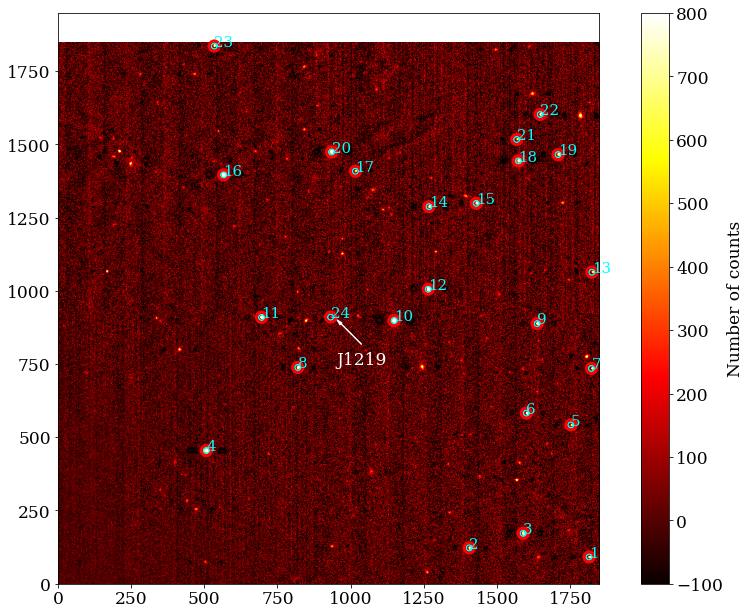

In [53]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(plotwidth, plotwidth*0.7))
im = ax.imshow(data, origin='lower', vmin=-100, vmax=800, cmap='hot', aspect='equal')
fig.colorbar(im, orientation='vertical', ax=ax, label='Number of counts')
apertures.plot(color='cyan', lw=1.5, alpha=1.0)
annulus_apertures.plot(color='red', lw=1.5, alpha=1.0)
for i in range(len(phot)):
    row = phot[i]
    textcolor = 'cyan'
    ax.text(row['xcenter'].value, row['ycenter'].value, str(i+1), color=textcolor, fontsize=15)
ax.arrow(937+100, 917-100, -70, 70, color='white', head_width=10, head_length=20)
ax.text(1037, 750, 'J1219', ha='center', color='white')
plt.show()

We then made use of the Aladin Lite website (https://aladin.u-strasbg.fr/AladinLite/) to identify these sources and obtain their Ks 2MASS magnitude (for those available). The list of objects is stored in ``table_acquisition_2mass.txt``.






In [56]:
df_2mass_objects = pd.read_csv('table_acquisition_2mass.txt', sep='\s+', header=0, comment='#')

# insert empty column to store result
nrows = len(df_2mass_objects)
emptycolumn = np.array([np.nan]*nrows)

prevcol = df_2mass_objects.columns.get_loc('error')
df_2mass_objects.insert(prevcol+1, 'Ks_mag_BLLac', emptycolumn)
df_2mass_objects

,object_id,ra,dec,type,Ks_mag,error,Ks_mag_BLLac
0,2,184.762864,36.928959,star,15.266,0.114,NaN
1,3,184.753239,36.935707,galaxy,15.080,0.109,NaN
2,4,184.826134,36.923149,galaxy,14.738,0.095,NaN
3,6,184.764511,36.955360,star,15.659,0.176,NaN
4,8,184.815866,36.944229,galaxy,15.595,0.172,NaN
5,9,184.771337,36.971058,star,14.758,0.085,NaN
6,10,184.800818,36.959835,galaxy,14.423,0.081,NaN
7,11,184.828495,36.949493,star,14.471,0.060,NaN
8,12,184.797096,36.967854,star,13.442,0.030,NaN
9,16,184.850862,36.969849,star,12.862,0.023,NaN


8Thanks to the data of the neighbor sources (``table_acquisition_2mass.txt``), we could estimate the Ks magnitude of our J1219 target using the Pogson law.

Furthermore, since we have used the Ks 2MASS magnitudes of the sources present in the acquisition image, we applied the filter correction factor previously computed (ksmag_filter_correction, $\Delta {\rm Ks}_{{\rm EMIR} - {\rm 2MASS}}$) to obtain the estimations of the Ks EMIR magnitude of the J1219 object.

In [57]:
flux1 = phot[phot['id'] == 24]['aper_sum_bkgsub'][0]

for i in range(nrows):
    object_id = df_2mass_objects.at[i, 'object_id']
    flux2 = phot[phot['id'] == object_id]['aper_sum_bkgsub'][0]
    df_2mass_objects.at[i, 'Ks_mag_BLLac'] = df_2mass_objects.at[i, 'Ks_mag'] - 2.5 * np.log10(flux1/flux2)
    # apply correction: Ks (EMIR) -> Ks (2MASS)
    df_2mass_objects.at[i, 'Ks_mag_BLLac'] += ksmag_filter_correction
df_2mass_objects

,object_id,ra,dec,type,Ks_mag,error,Ks_mag_BLLac
0,2,184.762864,36.928959,star,15.266,0.114,17.614988
1,3,184.753239,36.935707,galaxy,15.080,0.109,17.926280
2,4,184.826134,36.923149,galaxy,14.738,0.095,17.784113
3,6,184.764511,36.955360,star,15.659,0.176,17.929012
4,8,184.815866,36.944229,galaxy,15.595,0.172,17.761947
5,9,184.771337,36.971058,star,14.758,0.085,17.868346
6,10,184.800818,36.959835,galaxy,14.423,0.081,17.967734
7,11,184.828495,36.949493,star,14.471,0.060,17.534230
8,12,184.797096,36.967854,star,13.442,0.030,17.845228
9,16,184.850862,36.969849,star,12.862,0.023,17.462187


Due to the low number of sources with 2MASS data available in this region, we decided to use only the stars to derive the Ks magnitude of the J1219 object.

We then plot the resulting 2MASS Ks magnitudes of the J1219 object using the objects in its neighborhood as a reference for the photometric calibration. Stars are depicted with blue dots and galaxies with orange plus symbols. The red dashed line marks the median Ks magnitude of J1219 computed using only the stars in the calibration. The black dashed line indicates the synthetic Ks magnitude of J1219 computed from the EMIR spectra.

Median Ks mag: 17.80269745971597
Sigmag Ks mag: 0.2091785330198999
Sigmag/sqrt(npoints): 0.0790620539977097


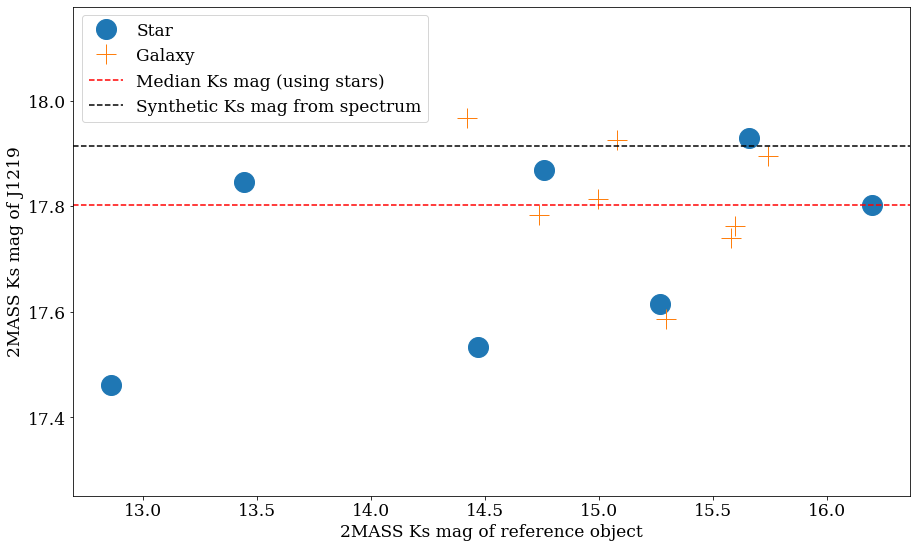

In [58]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(plotwidth, plotwidth*3/5))
id_saturated = []
label_used = []
useful_values = []
for i in range(nrows):
    object_id = df_2mass_objects.at[i, 'object_id']
    ks_mag = df_2mass_objects.at[i, 'Ks_mag']
    ks_mag_BLLac = df_2mass_objects.at[i, 'Ks_mag_BLLac']
    objtype = df_2mass_objects.at[i, 'type']
    if object_id == 24:
        marker = 's'
        color = 'C2'
        label = 'BL Lac'
    elif object_id in id_saturated:
        marker = 'x'
        color = 'C3'
        label = 'saturated star'
    else:
        if objtype == 'star':
            marker = 'o'
            color = 'C0'
            label = 'Star'
            edgecolor = 'black'
            useful_values.append(ks_mag_BLLac)
        else:
            marker = '+'
            color = 'C1'
            label = 'Galaxy'

    if label not in label_used:
        label_used.append(label)
    else:
        label = None
    ax.plot(ks_mag, ks_mag_BLLac, marker=marker, color=color, markersize=20, label=label, linestyle='')
ax.set_xlabel("2MASS Ks mag of reference object")
ax.set_ylabel("2MASS Ks mag of J1219")
median_ksmag = np.median(useful_values)
sigmag_ksmag = robust_std(useful_values)
ax.axhline(median_ksmag, label="Median Ks mag (using stars)", color='red', linestyle='dashed')
ax.axhline(ksmag_synthetic_emir.value, label="Synthetic Ks mag from spectrum", color='black', linestyle='dashed')
ax.legend(loc=2)
ymin, ymax = ax.get_ylim()
deltay = ymax - ymin
ymin -= deltay/3
ymax += deltay/3
ax.set_ylim([ymin, ymax])
plt.savefig('plots/photometry_acquisition.pdf',  bbox_inches='tight')


print("Median Ks mag: {}".format(median_ksmag))
print("Sigmag Ks mag: {}".format(sigmag_ksmag))
print("Sigmag/sqrt(npoints): {}".format(sigmag_ksmag/np.sqrt(len(useful_values))))


Finally, the median of these values (${\rm Ks}_{{\rm median}}$) and the synthetic Ks magnitude obtained from the EMIR spectra (${\rm Ks}_{{\rm synthetic}}$) were used to compute the flux correction factor as $10^{-0.4 \cdot ({\rm Ks}_{{\rm median}} - {\rm Ks}_{{\rm synthetic}})}$, which gave us a value $\sim$~1.1.

In [59]:
flux_correction_factor = 10**(-0.4*(median_ksmag-ksmag_synthetic_emir.value))
print('Flux correction factor: {}'.format(flux_correction_factor))

Flux correction factor: 1.1076796526208739


Even if the flux correction is not severe, we took into account the possible light losses and the flux of our target spectrum was corrected by this factor.

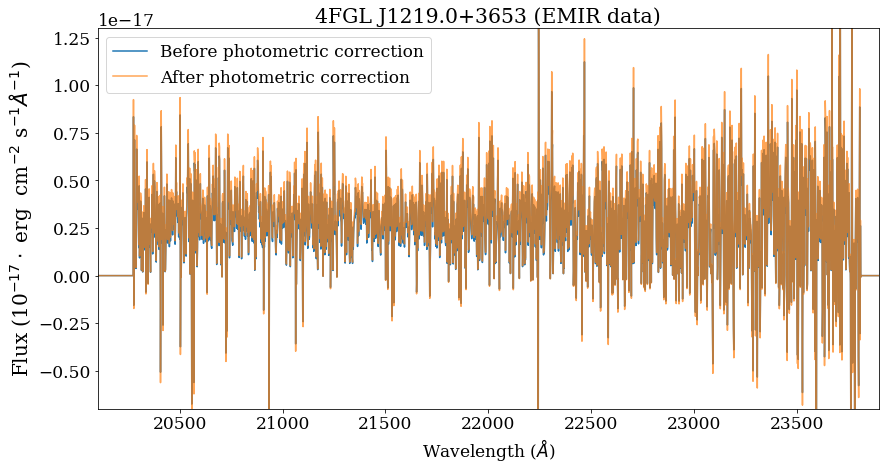

In [60]:
spcalibrated = flux_correction_factor * spcalibrated_ini

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(wave, spcalibrated_ini, label='Before photometric correction')
ax.plot(wave, spcalibrated, label='After photometric correction', alpha=0.7)
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Flux (10$^{-17} \cdot$ erg  cm$^{-2}$ s$^{-1} \AA^{-1}$)', size=20)
ax.set_title('4FGL J1219.0+3653 (EMIR data)')
ax.set_xlim([20100, 23900])
ax.set_ylim(-0.7*10**-17,1.3*10**-17)
ax.legend()
plt.savefig('plots/photometric_correction.pdf',  bbox_inches='tight')

##  <span style="color:blue"> ---> GALACTIC EXTINCTION CORRECTION</span> 

For the final calibration, we took into account the interstellar dust extinction, i.e, the effect of the dust along the line of sight that removes part of the flux by absorbing or scattering photons.


We corrected our J1219 spectrum for Galactic extinction by using the 'dust_extinction' Astropy package (https://dust-extinction.readthedocs.io/en/stable/\#) .

The color excess $E(B-V) = 0.0151$ for this target was retrieved from the NASA/IPAC Infrared Science Archive (https://irsa.ipac.caltech.edu/applications/DUST/) with coordinates: $\alpha =$12h 19m 15.41000s, $\beta =$+36d 57m 18.5000 (J2000 Equinox). 


We used the estimates of Galactic dust extinction from [Schlafly & Finkbeiner (2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...737..103S/abstract) and adopted the [Fitzpatrick
(1999)](https://ui.adsabs.harvard.edu/abs/1999PASP..111...63F/abstract) model for R$_{V}$ = 3.1 (blue line).

The derived correction factor (orange line) has values in the range [1.004 $-$ 1.006].

                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]
/Users/criscabe/opt/anaconda3/envs/py36/lib/python3.6/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")
                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]
/Users/criscabe/opt/anaconda3/envs/py36/lib/python3.6/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x un

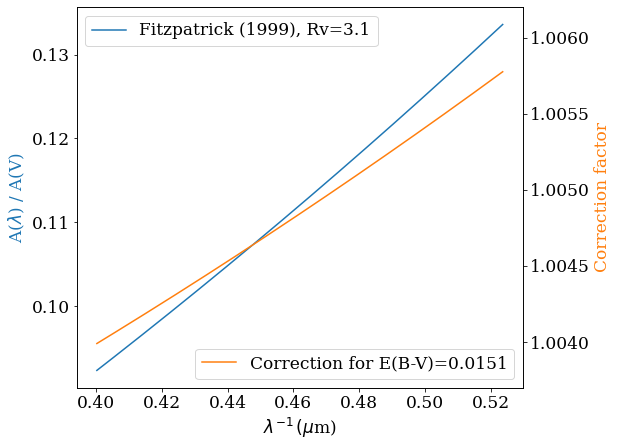

In [63]:
wave_units = (1/wave)*(10000)  # inverse wavelength in microns


ext = F99(Rv=3.1)
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(8, 7))
ax1.plot(wave_units, ext(wave_units), color='C0', label='Fitzpatrick (1999), Rv=3.1')
ax1.set_xlabel('$\lambda^{-1} \,(\mu$m)')
ax1.set_ylabel('A($\lambda$) / A(V)', color='C0')
ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(wave_units, 1/ext.extinguish(wave_units, Ebv=0.0151), color='C1', 
         label='Correction for E(B-V)=0.0151')
ax2.set_ylabel('Correction factor', color='C1')
ax2.legend(loc=4)
ax2.set_ylim(1.0037,1.0062)
plt.savefig('plots/curve_extinction.pdf',  bbox_inches='tight')

We apply this correction factor to our target spectrum and the effect is negligible.


/Users/criscabe/opt/anaconda3/envs/py36/lib/python3.6/site-packages/dust_extinction/helpers.py:28: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn("x has no units, assuming x units are inverse microns")
                This has been deprecated in v4.0 and support will be removed in v4.1.
                Starting with v4.0 classes must define a class attribute ``n_inputs``.
                Please consult the documentation for details.
                 [astropy.modeling.core]


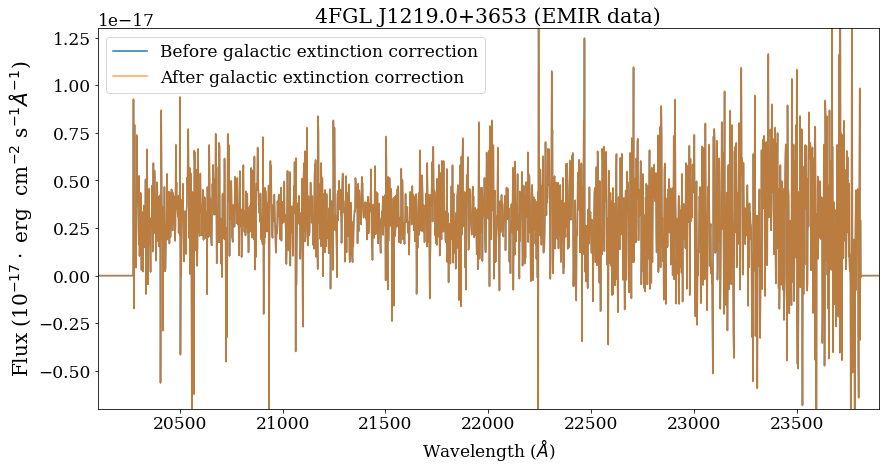

In [64]:
# apply galactic extinction correction
spcalibrated_ext = spcalibrated / ext.extinguish(wave_units, Ebv=0.0151)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
ax.plot(wave, spcalibrated, color='C0', label='Before galactic extinction correction')
ax.plot(wave, spcalibrated_ext, color='C1', label='After galactic extinction correction',alpha=0.7)
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Flux (10$^{-17} \cdot$ erg  cm$^{-2}$ s$^{-1} \AA^{-1}$)', size=20)
ax.set_title('4FGL J1219.0+3653 (EMIR data)')
ax.set_xlim([20100, 23900])
ax.set_ylim(-0.7*10**-17,1.3*10**-17)
ax.legend()
plt.savefig('plots/extinction_correction.pdf',  bbox_inches='tight')

##  <span style="color:blue"> ---> S/N ESTIMATION</span> 

The dispersion is constant in the EMIR spectrum: 1.73 (angstrom/pixel)

The SNR per pixel was computed using the algorithm explained in [Stoehr et al. (2008)](https://ui.adsabs.harvard.edu/abs/2008ASPC..394..505S/abstract)

In [70]:
# compute SNR per Angstrom or per pixel
def snra_spectrum(w_, sp_, window, i1=None, i2=None, binning=1, per_angstrom=True):
    if binning == 1:
        w = w_.copy()
        sp = sp_.copy()
    else:
        npix_ = len(sp_)
        k = 0
        w = []
        sp = []
        loop = True
        while loop:
            k1 = k * binning
            k2 = k1 + binning
            if k2 >= npix_:
                k2 = npix_
                loop = False
            ndum = k2 - k1
            w.append(np.sum(w_[k1:k2])/float(ndum))
            sp.append(np.sum(sp_[k1:k2])/float(ndum))
            k += 1
        w = np.array(w)
        sp = np.array(sp)

    i1 = int(i1/binning)
    i2 = int(i2/binning)
    window = int(window/binning)
    
    npix = len(sp)
    snra = np.zeros(npix, dtype=float)
    
    if i1 is None:
        i1 = 0
    if i2 is None:
        i2 = np-1

    for i in range(i1, i2+1):
        i1 = int(i - window/2)
        if i1 < 0:
            i1 = 0
        i2 = int(i + window/2)
        if i2 > npix:
            i2 = npix
        snr = der_snr(sp[i1:i2])
        if i == 0:
            disp = w[1]-w[0]
        elif i == npix-1:
            disp = w[npix-1]-w[npix-2]
        else:
            disp = (w[i+1]-w[i-1])/2
        if per_angstrom:
            snra[i] = snr/np.sqrt(disp)
        else:
            snra[i] = snr
    return w, sp, snra


In order to improve the S/N per pixel at the center of the spectrum, we applied a re-binning of 50 pixels.

The final calibrated spectra and their corresponding S/N per pixel are shown below:


Binning: 50,  dispersion: {86.5}


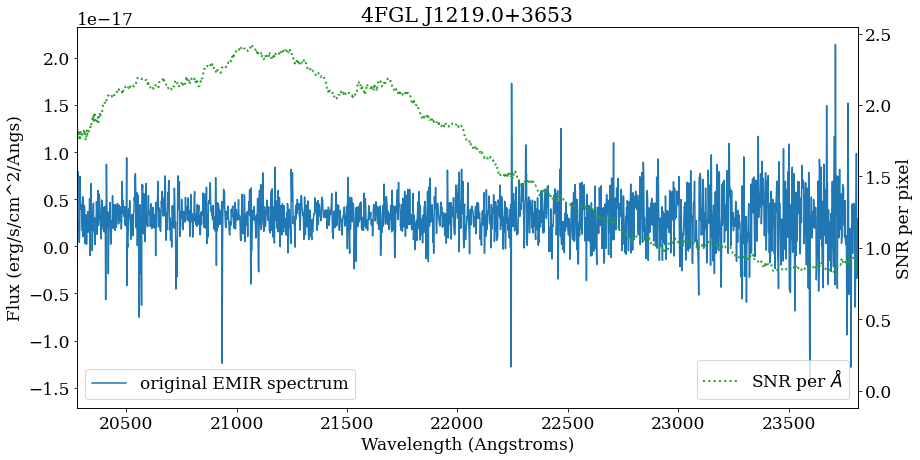

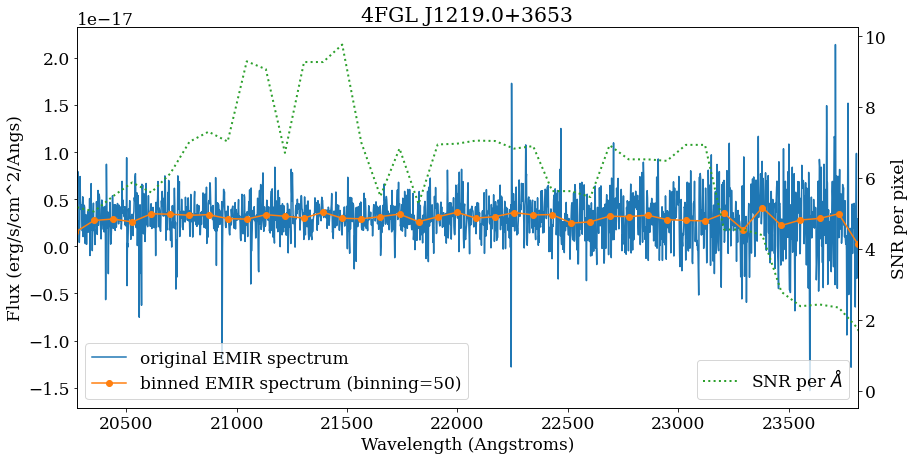

In [71]:
per_angstrom = False

for binning in [1, 50]:

    wave_snra, sp_snra, snra_emir = snra_spectrum(
            wave, spcalibrated_ext, window=500, i1=679, i2=2725, 
            binning=binning, per_angstrom=per_angstrom
        )

    with open('snrp_emir_spectrum_bin{:03d}.txt'.format(binning), 'tw') as f:
        for x, y in zip(wave_snra, snra_emir):
            f.write('{:8.3f}  {:e}\n'.format(x, y))
    with open('target_calibrated_EMIR_bin{:03d}.txt'.format(binning), 'tw') as f:
        for x, y in zip(wave_snra, sp_snra):
            f.write('{:8.3f}  {:e}\n'.format(x, y))

    fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(14, 7))
    ax1.plot(wave, spcalibrated_ext, label='original EMIR spectrum', color='C0', alpha=1.0)
    if binning > 1:
        ax1.plot(wave_snra, sp_snra, 'o-', label='binned EMIR spectrum (binning={})'.format(binning), color='C1', alpha=1.0)
        print('Binning: {},  dispersion: {}'.format(binning, set(wave_snra[1:] - wave_snra[:-1])))
    ax1.set_xlabel('Wavelength (Angstroms)')
    ax1.set_ylabel('Flux (erg/s/cm^2/Angs)')
    ax1.set_title('4FGL J1219.0+3653')
    ax1.legend(loc=3)
    ax1.set_xlim([20275, 23814])
    ax2 = ax1.twinx()
    ax2.plot(wave_snra, snra_emir, label='SNR per $\AA$', color='C2', linestyle='dotted', lw=2)
    if per_angstrom:
        ax2.set_ylabel('SNR per $\AA$')
    else:
        ax2.set_ylabel('SNR per pixel')
    ax2.legend(loc=4)